# MSDE631 SQL-NoSQL | Regis University
### Instructor: Dr. Busch

TITLE  | Date | Author |   Notes |
:-----:|:----:|:------:|:-------:|
Project, Part 5 |10 April 2023 | Ken Dizon | Version 1

**Activity 3: Assignment 5: PDA in MongoDB** 
You are to transform your PDA to a document database.
Transform you relation database you created for your PDA into a document database using MongoDB.
- Export your data from your SQL-PDA as CSV files.
- Use your exported data to create Mongo DB and collections.
- Execute a series of find() commands on your collections to show the implementation.

Note: Translation from a relational model DB to a NoSQL database requires some extra steps to make the NoSQL database useful. Use the RelationalToNoSQL notebook as your guide for your DB transformation. 

Submit the following:
- PDF file contains screenshots of the commands execution and results.
- The code you used to implement the document database.

**Contents**
1. Packages / Set Up
2. Exporting MySQL Tables
    * 2.2 Other Tables
3. Review data schemas
    * 3.2 Transform data
        - 3.2.1: Prod + Order in OrderDetails
        - 3.2.2: Cust_id in Orders
        - 3.2.3: Clinic_id in Customer
        - 3.2.4: Product and Clinic Tables
4. MongoDB Config
5. Migration of data to MongoDB
6. Accessing Nested Values

In [1]:
# The getpass library is designed for inputting passwords
import getpass
import datetime
import mysql.connector

# pprint stands for pretty printing
from pprint import pprint
from pymongo import MongoClient

In [2]:
# Set up the database connection
db = mysql.connector.connect(
  host="127.0.0.1",
  user="root",
    database='SM_DBMS',
    password=getpass.getpass('Enter Password: ')
  #password=input('Enter your password: '),
)

Enter Password:  ············


In [3]:
print(db.is_connected())

True


Setting `dictionary=True` during cursor creation makes the database return dictionaries, where the keys are table column names. Handier than trying to remember numeric indexes.

In [4]:
# Create cursor for data access object that can be used to either 
# iterate over the set of rows in a table or insert new rows into a table.
cursor = db.cursor(dictionary=True) 
cursor.execute('USE SM_DBMS')

## 2. Exporting MySQL Tables

In [5]:
query = """SHOW TABLES"""

cursor.execute(query)
result = cursor.fetchall()
for x in result:
    print(x)

{'Tables_in_sm_dbms': 'Clinic'}
{'Tables_in_sm_dbms': 'Customer'}
{'Tables_in_sm_dbms': 'OrderDetails'}
{'Tables_in_sm_dbms': 'Orders'}
{'Tables_in_sm_dbms': 'Product'}


In [6]:
query = """SELECT * FROM Product"""

cursor.execute(query)
product = list(cursor.fetchall())
product[:5]

[{'Product_id': 1,
  'Name': 'Knee braces',
  'Description': 'designed to support and protect the knee joint during physical activity or recovery from injury.',
  'Price': 22.02},
 {'Product_id': 2,
  'Name': 'Ankle braces',
  'Description': 'designed to provide stability and support for the ankle joint during physical activity or recovery from injury.',
  'Price': 97.14},
 {'Product_id': 3,
  'Name': 'Compression garments',
  'Description': 'designed to improve blood flow, reduce swelling, and support muscles during physical activity or recovery from injury.',
  'Price': 67.38},
 {'Product_id': 4,
  'Name': 'Ice packs',
  'Description': 'designed to reduce pain and swelling by applying cold therapy to the affected area.',
  'Price': 16.94},
 {'Product_id': 5,
  'Name': 'Heating pads',
  'Description': 'designed to improve blood flow, reduce muscle tension, and promote healing by applying heat therapy to the affected area.',
  'Price': 16.49}]

In [7]:
# Quick check to make sure we have all the results.
len(product)

30

In [8]:
product[15]

{'Product_id': 16,
 'Name': 'Electrotherapy devices',
 'Description': 'designed to provide pain relief and promote healing through the use of electrical impulses.',
 'Price': 23.11}

### 2.2 Other Tables **4**

In [9]:
query = """SELECT * FROM Clinic"""

cursor.execute(query)
clinic = list(cursor.fetchall())
clinic[0]

{'Clinic_id': 1,
 'Name': 'Garcia, Harrell and Phillips',
 'Address': '3197 Koch Tunnel Apt. 731',
 'City': 'New Mikeview',
 'State': 'Nevada',
 'Zip': 54039,
 'Phone': '520-541-1189x358'}

In [10]:
query = """SELECT * FROM Customer"""

cursor.execute(query)
customer = list(cursor.fetchall())
customer[0]

{'Customer_id': 1,
 'Start_date': datetime.date(2018, 9, 1),
 'First_name': 'David',
 'Last_name': 'Harding',
 'DOB': datetime.date(1941, 12, 30),
 'Phone': '620.445.2906',
 'Email': 'tsmith@example.org',
 'Clinic_id': 11}

In [11]:
query = """SELECT * FROM OrderDetails"""

cursor.execute(query)
orderdetails = list(cursor.fetchall())
orderdetails[0]

{'OrderDetails_id': 1,
 'Product_id': 16,
 'Order_id': 403,
 'Quantity': 7,
 'Total': 161.77}

In [12]:
query = """SELECT * FROM Orders"""

cursor.execute(query)
orders = list(cursor.fetchall())
orders[0]

{'Order_id': 1, 'Order_date': datetime.date(2022, 12, 18), 'Customer_id': 815}

In [13]:
orders[402]

{'Order_id': 403, 'Order_date': datetime.date(2023, 1, 4), 'Customer_id': 2721}

## 3.  Review data schemas
- My **MySQL** database demonstrates relating tables by primary and foreign keys which are utilized through joins.
- **Objective:** to embed sub-documents in the document that contains the information from the join:
    * Plan and understand what your final result will look like, before you ever execute your code. 
    * Consider using different linking strategies. 

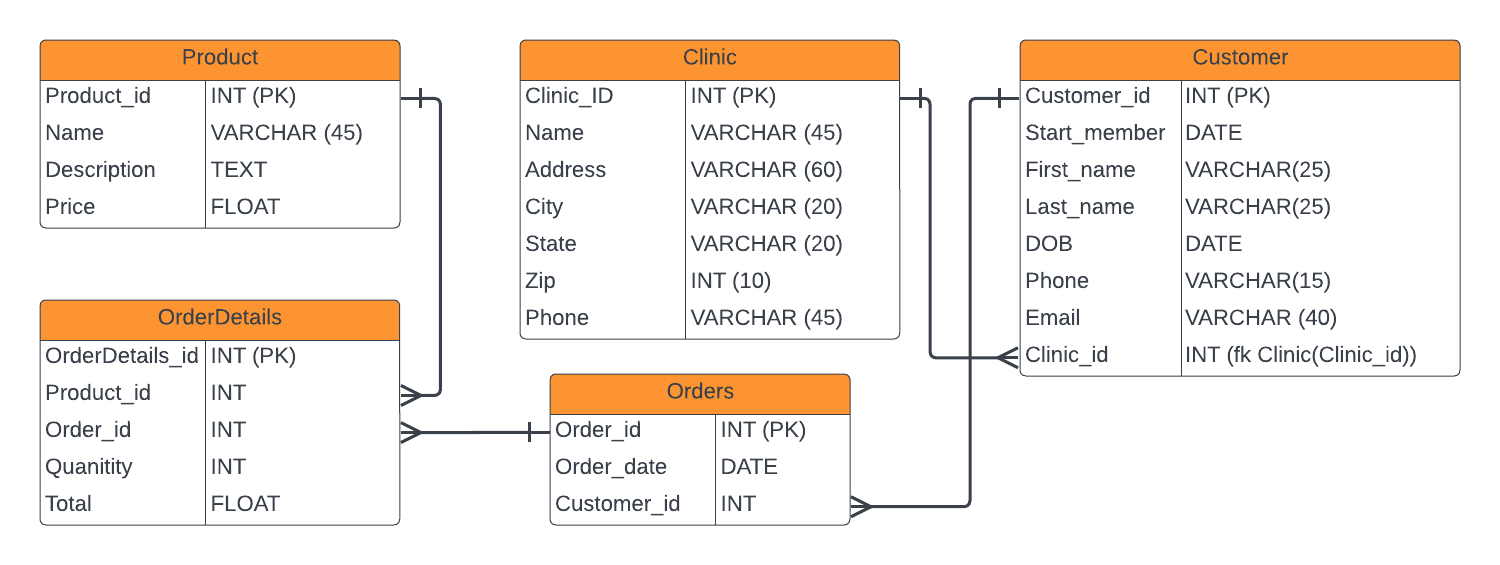

Originally, with foreign keys, a record in the **OrderDetails** table:

```
{ 
    'OrderDetails_id': 1,
    'Product_id': 16,
    'Order_id': 403,
    'Quantity': 7,
    'Total': 161.77}
}
```

- Task: need to relate the `Product_id` + `Order_id` with the OrderDetails.

We want to replace the `Product_ID` **value** with the corresponding entry in the Product table: 

```
{
    'Product_id': 16,
    'Name': 'Electrotherapy devices',
    'Description': 'designed to provide pain relief and promote healing through the use of electrical impulses.',
    'Price': 23.11
}
```

And the `OrderID` **value** with the corresponding entry in the Orders table:

```
{
    'Order_id': 403,
    'Order_date': datetime.date(2023, 1, 4),
    'Customer_id': 2721
}
```

Putting it all together, the first document in the OrderDetials table looks like this:

```
{ 
    'OrderDetails_ID': 
    {
        'OrderDetails_id': 1,
        'Product_id': 16,
        'Order_id': 403,
        'Quantity': 7,
        'Total': 161.77
    },
    'Product_id':
    {
        'Product_id': 16,
        'Name': 'Electrotherapy devices',
        'Description': 'designed to provide pain relief and promote healing through the use of electrical impulses.',
        'Price': 23.11
    },
    'Order_id':
    {
         'Order_id': 403,
         'Order_date': datetime.date(2023, 1, 4),
         'Customer_id': 2721}
}
```

In [14]:
import datetime

one_od = \
{ 
    'OrderDetails_id': 
    {
        'OrderDetails_id': 1,
        'Product_id': 16,
        'Order_id': 403,
        'Quantity': 7,
        'Total': 161.77
    },
    'Product_id':
    {
        'Product_id': 16,
        'Name': 'Electrotherapy devices',
        'Description': 'designed to provide pain relief and promote healing through the use of electrical impulses.',
        'Price': 23.11
    },
    'Order_id':
    {
         'Order_id': 403,
         'Order_date': datetime.date(2023, 1, 4),
         'Customer_id': 2721}
}

In [15]:
pprint(one_od, indent=2)

{ 'OrderDetails_id': { 'OrderDetails_id': 1,
                       'Order_id': 403,
                       'Product_id': 16,
                       'Quantity': 7,
                       'Total': 161.77},
  'Order_id': { 'Customer_id': 2721,
                'Order_date': datetime.date(2023, 1, 4),
                'Order_id': 403},
  'Product_id': { 'Description': 'designed to provide pain relief and promote '
                                 'healing through the use of electrical '
                                 'impulses.',
                  'Name': 'Electrotherapy devices',
                  'Price': 23.11,
                  'Product_id': 16}}


In [16]:
pprint(one_od['OrderDetails_id'], width=1, indent=2)

{ 'OrderDetails_id': 1,
  'Order_id': 403,
  'Product_id': 16,
  'Quantity': 7,
  'Total': 161.77}


In [17]:
pprint(one_od['Product_id'],indent=2)

{ 'Description': 'designed to provide pain relief and promote healing through '
                 'the use of electrical impulses.',
  'Name': 'Electrotherapy devices',
  'Price': 23.11,
  'Product_id': 16}


In [18]:
pprint(one_od['Order_id'], width=1, indent=2)

{ 'Customer_id': 2721,
  'Order_date': datetime.date(2023, 1, 4),
  'Order_id': 403}


In [19]:
# Finding the date
pprint(one_od['Order_id']['Order_date'], width=1,indent=2)

datetime.date(2023, 1, 4)


### 3.2 Transform Data
- 3.2.1) `Product_id + Order_id` within the OrderDetails to make sub-documents
- 3.2.2) `Customer_id` within Orders
- 3.2.3) `Clinic_id` within Customer

In [20]:
for od in orderdetails[:5]:
    od['Product_id'] = product[od['Product_id']]
    od['Order_id'] = orders[od['Order_id']]
    print(od)

{'OrderDetails_id': 1, 'Product_id': {'Product_id': 17, 'Name': 'Insoles', 'Description': 'designed to provide additional support and cushioning for the feet during physical activity or recovery from injury.', 'Price': 75.63}, 'Order_id': {'Order_id': 404, 'Order_date': datetime.date(2022, 6, 21), 'Customer_id': 1943}, 'Quantity': 7, 'Total': 161.77}
{'OrderDetails_id': 2, 'Product_id': {'Product_id': 28, 'Name': 'GPS watches', 'Description': 'designed to track distance, pace, and other metrics during physical activity.', 'Price': 7.44}, 'Order_id': {'Order_id': 1170, 'Order_date': datetime.date(2023, 3, 1), 'Customer_id': 2767}, 'Quantity': 1, 'Total': 85.41}
{'OrderDetails_id': 3, 'Product_id': {'Product_id': 22, 'Name': 'Shin guards', 'Description': 'designed to protect the shins from impact during contact sports.', 'Price': 16.0}, 'Order_id': {'Order_id': 1936, 'Order_date': datetime.date(2021, 6, 16), 'Customer_id': 1364}, 'Quantity': 2, 'Total': 80.42}
{'OrderDetails_id': 4, 'Pro

In [21]:
# New
orderdetails[0]

{'OrderDetails_id': 1,
 'Product_id': {'Product_id': 17,
  'Name': 'Insoles',
  'Description': 'designed to provide additional support and cushioning for the feet during physical activity or recovery from injury.',
  'Price': 75.63},
 'Order_id': {'Order_id': 404,
  'Order_date': datetime.date(2022, 6, 21),
  'Customer_id': 1943},
 'Quantity': 7,
 'Total': 161.77}

In [22]:
# old
orderdetails[-1]

{'OrderDetails_id': 5000,
 'Product_id': 1,
 'Order_id': 370,
 'Quantity': 3,
 'Total': 66.06}

**Note:** Since we made changes, we need to refresh the table documents

In [23]:
# Reset the document
query = """SELECT * FROM OrderDetails"""

cursor.execute(query)
orderdetails = list(cursor.fetchall())
orderdetails[0]

{'OrderDetails_id': 1,
 'Product_id': 16,
 'Order_id': 403,
 'Quantity': 7,
 'Total': 161.77}

In [24]:
# Using JSON
import json

for od in orderdetails[:5]:
    od['Product_id'] = list(filter(lambda Pid: Pid['Product_id'] == od['Product_id'], product))[0]
    od['Order_id'] = list(filter(lambda Pid: Pid['Order_id'] == od['Order_id'], orders))[0]
    print(json.dumps(od, indent=2, default=str))

{
  "OrderDetails_id": 1,
  "Product_id": {
    "Product_id": 16,
    "Name": "Electrotherapy devices",
    "Description": "designed to provide pain relief and promote healing through the use of electrical impulses.",
    "Price": 23.11
  },
  "Order_id": {
    "Order_id": 403,
    "Order_date": "2023-01-04",
    "Customer_id": 2721
  },
  "Quantity": 7,
  "Total": 161.77
}
{
  "OrderDetails_id": 2,
  "Product_id": {
    "Product_id": 27,
    "Name": "Hydration packs",
    "Description": "designed to provide hands-free hydration during outdoor activities.",
    "Price": 85.41
  },
  "Order_id": {
    "Order_id": 1169,
    "Order_date": "2022-07-25",
    "Customer_id": 56
  },
  "Quantity": 1,
  "Total": 85.41
}
{
  "OrderDetails_id": 3,
  "Product_id": {
    "Product_id": 21,
    "Name": "Mouthguards",
    "Description": "designed to protect the teeth and jaw from impact during contact sports.",
    "Price": 40.21
  },
  "Order_id": {
    "Order_id": 1935,
    "Order_date": "2021-06-11

In [25]:
# Finding the date
pprint(orderdetails[0]['Order_id']['Order_date'], width=1,indent=2)

datetime.date(2023, 1, 4)


In [26]:
# Reset the document
query = """SELECT * FROM OrderDetails"""

cursor.execute(query)
orderdetails = list(cursor.fetchall())
orderdetails[0]

{'OrderDetails_id': 1,
 'Product_id': 16,
 'Order_id': 403,
 'Quantity': 7,
 'Total': 161.77}

#### 3.2.1: OrderDetails

In [27]:
new_od = []

for od in orderdetails:
    od['Product_id'] = list(filter(lambda Pid: Pid['Product_id'] == od['Product_id'], product))[0]
    od['Order_id'] = list(filter(lambda Pid: Pid['Order_id'] == od['Order_id'], orders))[0]
    od['Order_id']['Order_date'] = datetime.datetime(orderdetails[0]['Order_id']['Order_date'].year,
                                         orderdetails[0]['Order_id']['Order_date'].month,
                                         orderdetails[0]['Order_id']['Order_date'].day)
    new_od.append(od)

In [28]:
new_od[:3]

[{'OrderDetails_id': 1,
  'Product_id': {'Product_id': 16,
   'Name': 'Electrotherapy devices',
   'Description': 'designed to provide pain relief and promote healing through the use of electrical impulses.',
   'Price': 23.11},
  'Order_id': {'Order_id': 403,
   'Order_date': datetime.datetime(2023, 1, 4, 0, 0),
   'Customer_id': 2721},
  'Quantity': 7,
  'Total': 161.77},
 {'OrderDetails_id': 2,
  'Product_id': {'Product_id': 27,
   'Name': 'Hydration packs',
   'Description': 'designed to provide hands-free hydration during outdoor activities.',
   'Price': 85.41},
  'Order_id': {'Order_id': 1169,
   'Order_date': datetime.datetime(2023, 1, 4, 0, 0),
   'Customer_id': 56},
  'Quantity': 1,
  'Total': 85.41},
 {'OrderDetails_id': 3,
  'Product_id': {'Product_id': 21,
   'Name': 'Mouthguards',
   'Description': 'designed to protect the teeth and jaw from impact during contact sports.',
   'Price': 40.21},
  'Order_id': {'Order_id': 1935,
   'Order_date': datetime.datetime(2023, 1, 4, 

In [29]:
new_od[0]['OrderDetails_id']

1

In [30]:
new_od[0]['Order_id']['Order_date']

datetime.datetime(2023, 1, 4, 0, 0)

#### 3.2.2: Customer_id in Orders

In [31]:
query = """SELECT * FROM Orders"""

cursor.execute(query)
orders = list(cursor.fetchall())
orders[0]

{'Order_id': 1, 'Order_date': datetime.date(2022, 12, 18), 'Customer_id': 815}

In [32]:
new_orders = []

for cust in orders:
    cust['Customer_id'] = list(filter(lambda cust_id: cust_id['Customer_id'] == cust['Customer_id'], customer))[0]
    cust['Order_date'] = datetime.datetime(orders[0]['Order_date'].year,
                                           orders[0]['Order_date'].month,
                                           orders[0]['Order_date'].day)
    cust['Customer_id']['Start_date'] = datetime.datetime(orders[0]['Customer_id']['Start_date'].year,
                                                          orders[0]['Customer_id']['Start_date'].month,
                                                          orders[0]['Customer_id']['Start_date'].day)
    cust['Customer_id']['DOB'] = datetime.datetime(orders[0]['Customer_id']['DOB'].year,
                                                   orders[0]['Customer_id']['DOB'].month,
                                                   orders[0]['Customer_id']['DOB'].day)
    new_orders.append(cust)

In [33]:
new_orders[0]

{'Order_id': 1,
 'Order_date': datetime.datetime(2022, 12, 18, 0, 0),
 'Customer_id': {'Customer_id': 815,
  'Start_date': datetime.datetime(2020, 12, 30, 0, 0),
  'First_name': 'Jeffrey',
  'Last_name': 'Bailey',
  'DOB': datetime.datetime(1977, 7, 10, 0, 0),
  'Phone': '376-345-2633x492',
  'Email': 'candace73@example.net',
  'Clinic_id': 4}}

#### 3.2.3: Clinic_id in Customers

In [34]:
new_customer = []

for clin in customer:
    clin['Clinic_id'] = list(filter(lambda clin_id: clin_id['Clinic_id'] == clin['Clinic_id'], clinic))[0]
    clin['Start_date'] = datetime.datetime(customer[0]['Start_date'].year,
                                           customer[0]['Start_date'].month,
                                           customer[0]['Start_date'].day)
    clin['DOB'] = datetime.datetime(customer[0]['DOB'].year,
                                    customer[0]['DOB'].month,
                                    customer[0]['DOB'].day)
    new_customer.append(clin)

In [35]:
new_customer[0]

{'Customer_id': 1,
 'Start_date': datetime.datetime(2018, 9, 1, 0, 0),
 'First_name': 'David',
 'Last_name': 'Harding',
 'DOB': datetime.datetime(1941, 12, 30, 0, 0),
 'Phone': '620.445.2906',
 'Email': 'tsmith@example.org',
 'Clinic_id': {'Clinic_id': 11,
  'Name': 'Gross-Strong',
  'Address': '05364 Pennington Pike Apt. 188',
  'City': 'East Edward',
  'State': 'Rhode Island',
  'Zip': 89804,
  'Phone': '001-602-202-1907'}}

## 4. MongoDB Config
- Ensure that server is running via terminal

In [36]:
# connects default host
mongoClient = MongoClient()

for db in mongoClient.list_databases():
	pprint(db, width=1, indent=2)

{ 'empty': False,
  'name': 'SM_DBMS',
  'sizeOnDisk': 1601536}
{ 'empty': False,
  'name': 'SkiData',
  'sizeOnDisk': 163840}
{ 'empty': False,
  'name': 'admin',
  'sizeOnDisk': 40960}
{ 'empty': False,
  'name': 'config',
  'sizeOnDisk': 110592}
{ 'empty': False,
  'name': 'database1',
  'sizeOnDisk': 1401794560}
{ 'empty': False,
  'name': 'local',
  'sizeOnDisk': 73728}


In [37]:
mongoClient.drop_database('SM_DBMS')

In [38]:
mongoDB = mongoClient.SM_DBMS
# List collection in mongoDB Database: SM_DBMS
SM_DBMS_collections = mongoDB.list_collection_names()

# Print the collection names
print("Collections in the database:")
for collection_name in SM_DBMS_collections:
    print(collection_name)

Collections in the database:


## 5. Migration of Data

In [39]:
Product_C = mongoDB.Product
Clinic_C = mongoDB.Cilinc
Orders_C = mongoDB.Orders
OrderDetails_C = mongoDB.OrderDetails
Customer_C = mongoDB.Customer

In [40]:
OrderDetails_C.insert_many(new_od)
Orders_C.insert_many(new_orders)
Customer_C.insert_many(new_customer)

Product_C.insert_many(product)
Clinic_C.insert_many(clinic)

In [41]:
mongoDB = mongoClient.SM_DBMS
# List collection in mongoDB Database: SM_DBMS
SM_DBMS_collections = mongoDB.list_collection_names()

# Print the collection names
print("Collections in the database:")
for collection_name in SM_DBMS_collections:
    print(collection_name)

Collections in the database:
Product
Cilinc
OrderDetails
Orders
Customer


**NOTE:** This project was tedious due to the working out the syntax for transforming data in which NoSQL MongoDB would accept the dates in the JSON/Dictionary formats. One should consider date objects carefully. 

## 6. Accessing Nested Values:
- Q: I want to find all `orderdetials` for customer_id `40`?

In [43]:
# Find all documents with 'Customer_id' equal to 40
customer_id = 40
cursor = OrderDetails_C.find({'Order_id.Customer_id': customer_id})

# Iterate through the cursor and print the documents
for document in cursor:
    pprint(document)

{'OrderDetails_id': 4373,
 'Order_id': {'Customer_id': 40,
              'Order_date': datetime.datetime(2023, 1, 4, 0, 0),
              'Order_id': 368},
 'Product_id': {'Description': 'designed to aid in muscle recovery, such as '
                               'massage guns, percussive therapy devices, or '
                               'pneumatic compression boots.',
                'Name': 'Recovery tools',
                'Price': 17.29,
                'Product_id': 30},
 'Quantity': 3,
 'Total': 51.87,
 '_id': ObjectId('643ee563be43dedd1c1db6d0')}


- Find all `customer ID` for those beloning to `clinic_id = 1`

In [47]:
# Belongs to clinic_id = 1 
clinic_id = 1
clinic[0]['Name']

'Garcia, Harrell and Phillips'

In [49]:
# Query the collection to find documents with Clinic_id.Clinic_id = clinic_id
result = Customer_C.find({'Clinic_id.Clinic_id': clinic_id}, {'Customer_id': 1})

# Extract Customer_id from the result and store in a list
customer_ids = [doc['Customer_id'] for doc in result]
print(customer_ids)

[19, 28, 82, 97, 131, 138, 148, 152, 187, 224, 242, 268, 312, 321, 348, 387, 430, 431, 478, 493, 603, 634, 664, 710, 711, 717, 747, 767, 791, 844, 846, 935, 970, 971, 976, 1011, 1019, 1023, 1028, 1073, 1082, 1086, 1114, 1132, 1143, 1151, 1183, 1194, 1212, 1233, 1238, 1264, 1284, 1287, 1317, 1318, 1321, 1323, 1336, 1345, 1357, 1363, 1570, 1618, 1669, 1691, 1695, 1704, 1751, 1911, 1912, 1934, 1958, 1960, 1964, 1990, 2007, 2015, 2056, 2064, 2080, 2086, 2162, 2186, 2194, 2243, 2332, 2340, 2383, 2412, 2420, 2425, 2439, 2444, 2446, 2461, 2470, 2476, 2486, 2525, 2593, 2617, 2619, 2625, 2629, 2643, 2698, 2713, 2764, 2832, 2891]


In [53]:
len(customer_ids)

111